##  Speed and Performance of GB libraries

Please make sure to install the following powerful packages for boosting:
* [xgboost](https://anaconda.org/conda-forge/xgboost)
* [lightgbm](https://anaconda.org/conda-forge/lightgbm)
* [catboost](https://tech.yandex.com/catboost/doc/dg/concepts/python-installation-docpage/)

In this task you are asked to compare the **training time** of the **GBDT**, the
Gradient Boosted Decision Trees, as implemeted by different popular ML libraries.
The dataset you shall use is the [UCI Breast Cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).
You should study the parameters of each library and establish the **correspondence**
between them.

The plan is as follows:
1. Take the **default** parameter settings, measure the training time, and plot
the ROC curves;
2. Use grid search with the $3$-fold cross valiadation to choose the best model.
Then measure the training time as a function of (separately) **tree depth** and **the
number of estimators in the ensemble**, finally **plot the ROC** curves of the best
models.

You need to make sure that you are comparing **comparable** classifiers, i.e. with
**the same tree and ensemble hyperparameters**.

<span style="color:green">**NOTE**</span> You need figure out how to make parameter settings
compatible. One possible way to understand the correspondence is to study the docs. You may
choose the default parameters from any library.

Please plot **three** ROC curves, one per library, on the same **one plot**
with a *comprehensible [legend](https://matplotlib.org/users/legend_guide.html)*.

A useful command for timing is IPython's [**timeit** cell magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit). 

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

/Users/a18339743/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## roc curve

In [3]:
def plot_curve(estimators):
    plt.subplot()
    for estimator in estimators:
        estimator_name = type(estimator).__name__
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        print(f"roc_auc for {estimator_name}:", roc_auc)
        plt.plot(fpr, tpr, label=estimator_name)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

## training time

In [4]:
catboost_clf = CatBoostClassifier(learning_rate=0.1, verbose=False)
lightgbm_clf = LGBMClassifier(learning_rate=0.1)
xgboost_clf = XGBClassifier(learning_rate=0.1)

In [5]:
%%timeit -r 4
catboost_clf.fit(X_train, y_train)

1.74 s ± 31.7 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)


In [6]:
%%timeit -r 4
lightgbm_clf.fit(X_train, y_train)

25.9 ms ± 859 µs per loop (mean ± std. dev. of 4 runs, 10 loops each)


In [7]:
%%timeit -r 4
xgboost_clf.fit(X_train, y_train)

21.9 ms ± 156 µs per loop (mean ± std. dev. of 4 runs, 10 loops each)


roc_auc for CatBoostClassifier: 0.9619932432432432
roc_auc for LGBMClassifier: 0.9451013513513513
roc_auc for XGBClassifier: 0.9557432432432432


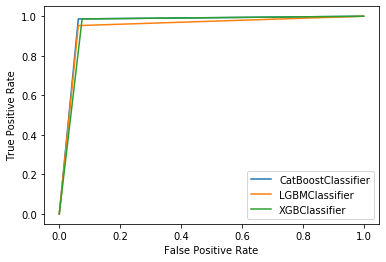

In [8]:
plot_curve([catboost_clf, lightgbm_clf, xgboost_clf])

## best score

In [9]:
estimators_grid = {'n_estimators': [80, 100, 120, 150],
                   'max_depth': [3, 5, 10]
                  }
catboost_cv = GridSearchCV(catboost_clf, estimators_grid, cv=3, n_jobs=-1)
lightgbm_cv = GridSearchCV(lightgbm_clf, estimators_grid, cv=3, n_jobs=-1)
xgboost_cv = GridSearchCV(xgboost_clf, estimators_grid, cv=3, n_jobs=-1)

In [10]:
start_time = time()
catboost_cv.fit(X_train, y_train)
end_time = time()
print(f"catboost cv time: {end_time - start_time:.2f}, best score {catboost_cv.best_score_:.4f}")

start_time = time()
lightgbm_cv.fit(X_train, y_train)
end_time = time()
print(f"lightgbm cv time: {end_time - start_time:.2f}, best score {lightgbm_cv.best_score_:.4f}")

start_time = time()
xgboost_cv.fit(X_train, y_train)
end_time = time()
print(f"xgboost cv time: {end_time - start_time:.2f}, best score {xgboost_cv.best_score_:.4f}")

catboost cv time: 40.37, best score 0.9706
lightgbm cv time: 0.30, best score 0.9648
xgboost cv time: 1.09, best score 0.9677


roc_auc for CatBoostClassifier: 0.9744932432432432
roc_auc for LGBMClassifier: 0.9451013513513513
roc_auc for XGBClassifier: 0.9557432432432432


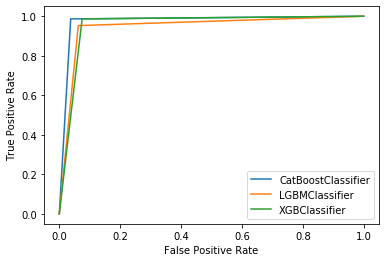

In [11]:
plot_curve([catboost_cv.best_estimator_,
            lightgbm_cv.best_estimator_,
            xgboost_cv.best_estimator_
           ])